In [1]:
import numpy as N
import lookup
import itam
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

To run ITAM you need to provide:
+ a lookup table of the inverse CDF
+ a lookup table of the target power spectrum.
+ the rescaling factor to match the field cell-density variance to the variance computed from the power spectrum.

Examples of such files are in the folder 'data_itam/'. They were written by using the module lookup.py module

The function *lookup_Pk* writes the lookup table of the target nonlinear power spectrum with Planck cosmology using CLASS (you can easily modify the cosmological parameters directly inside the function).

The function *lookup_ppf* writes the target inverse CDF (percentile point function) of the simulation, smoothed at the scale $R_{th}$. In my case density.npy is the binary file containing the density of the simulation (not included in data_itam/). It also saves the just mentioned rescaling factor.

In the case you want to implement an analytical one point mapping, take a look at logITAM.py module, where the Eq. 16 from the paper is implemented.

In [2]:
lookup.lookup_Pk(cosmology='planck',nonlinear=0) # linear power spectrum, useful for the initialization
lookup.lookup_Pk(cosmology='planck',nonlinear=1) # target power spectrum
lookup.lookup_ppf(nsamples=100000, boxsize=256.0, Rth=1.0,density='data_itam/density.npy', pathpk='data_itam/planck_pk.txt',  saveto_ppf='data_itam/_ppf.txt',
        saveto_rescale='data_itam/rescale_factor.txt')

saving data_itam/planck_pk_linear.txt
saving data_itam/planck_pk.txt
saving data_itam/_ppf.txt
cell density variance= 9.105349506994955 theoretical expected variance 9.705797447884882
ratio= 0.9381351255150314
saving data_itam/rescale_factor.txt


/home/federico/Documenti/PhD/github_public/ITAM/lookup.py:155: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sigma2, _ = quad(integrand, k_min, k_max, args = args, epsabs = 1e-08, epsrel = 1e-08, limit = 100)


In [3]:
itm = itam.ITAM(boxsize=256.,ng=256, beta=1.,Rth=1.,eps=0.001,Deps=0.001,pathto_linpk='data_itam/planck_pk_linear.txt',
            pathto_pk='data_itam/planck_pk.txt',pathto_ppf = 'data_itam/_ppf.txt',saveto='data_itam/',
            pathto_rescale='data_itam/rescale_factor.txt' , plotty=0)

you specified the linear power spectrum for the initilization
iteration = 1
eps = 0.76599 Deps =0.30550
iteration = 2
eps = 0.36634 Deps =1.09094
iteration = 3
eps = 0.16044 Deps =1.28333
iteration = 4
eps = 0.07017 Deps =1.28643
iteration = 5
eps = 0.03550 Deps =0.97679
iteration = 6
eps = 0.02245 Deps =0.58132
iteration = 7
eps = 0.01682 Deps =0.33463
iteration = 8
eps = 0.01370 Deps =0.22741
iteration = 9
eps = 0.01156 Deps =0.18583
iteration = 10
eps = 0.00990 Deps =0.16773
iteration = 11
eps = 0.00856 Deps =0.15646
iteration = 12
eps = 0.00745 Deps =0.14784
iteration = 13
eps = 0.00653 Deps =0.14132
iteration = 14
eps = 0.00576 Deps =0.13489
iteration = 15
eps = 0.00509 Deps =0.13042
iteration = 16
eps = 0.00452 Deps =0.12701
iteration = 17
eps = 0.00402 Deps =0.12444
iteration = 18
eps = 0.00358 Deps =0.12179
iteration = 19
eps = 0.00320 Deps =0.11910
iteration = 20
eps = 0.00286 Deps =0.11801
iteration = 21
eps = 0.00256 Deps =0.11736
iteration = 22
eps = 0.00229 Deps =0.11725
i

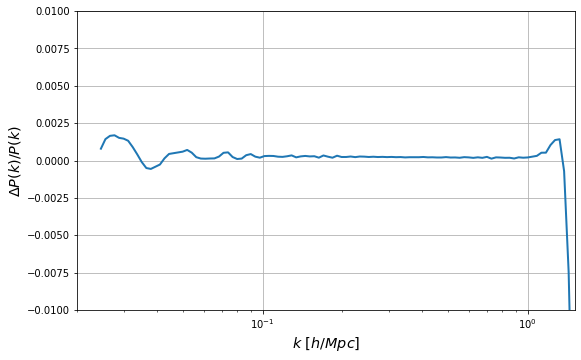

In [4]:
plt.figure(figsize=(1.62*5.5,5.5))
with warnings.catch_warnings():
    warnings.simplefilter( "ignore" , category = RuntimeWarning )
    plt.semilogx(itm.k,(itm.pk-itm.pk_ng)/itm.pk,lw=2.)
plt.ylim([-0.01,0.01])
plt.xlim([0.02,1.5])
plt.xlabel('$k \ [h/Mpc]$',fontsize='x-large')
plt.ylabel(r'$\Delta P(k)/P(k)$',fontsize='x-large')
plt.grid()
plt.show()

#### many realizations

In [6]:
from multiprocessing import cpu_count
print(cpu_count())

itm.make_covariance(nreal=100,cores=4)

8
making 100 realizations
saving data_itam/kbins.txt
implementing parallel execution with 4 cores
spent 16.135088872909545 minutes
0.16135088872909545 minutes per realization
saving data_itam/psvals_g.txt
saving data_itam/psvals_ng.txt


0

In [7]:
kbins = N.loadtxt('data_itam/kbins.txt')
kk,pk = N.loadtxt('data_itam/planck_pk.txt')
psvals = N.loadtxt('data_itam/psvals_ng.txt').T
psvals_g = N.loadtxt('data_itam/psvals_g.txt').T
meanPk = N.mean(psvals,axis=1)
sigmaPk = N.std(psvals,axis=1)

meanPk_g = N.mean(psvals_g,axis=1)
sigmaPk_g = N.std(psvals_g,axis=1)

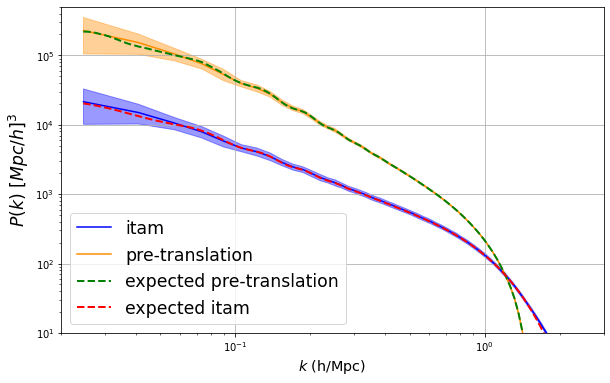

In [8]:
fig, ax = plt.subplots(figsize=(6*1.62,6))

ax.plot(kbins,meanPk,label='itam',c='b')
ax.plot(kbins,meanPk_g,label='pre-translation',c='darkorange')

ax.fill_between(kbins,meanPk_g+sigmaPk_g,meanPk_g-sigmaPk_g,alpha=0.4,color='darkorange')
ax.fill_between(kbins,meanPk+sigmaPk,meanPk-sigmaPk,alpha=0.4,color='b')
ax.plot(itm.k,itm.pk_g,'--g',label='expected pre-translation',lw=2.0)
ax.plot(itm.k,itm.pk,'--r',label='expected itam',lw=2.0)
ax.set_xlabel(r'$k$ (h/Mpc)',size='x-large')
ax.set_ylabel(r'$P(k)$ $(Mpc/h)^3$',size='large')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize='xx-large')
ax.set_ylabel('$P(k) \ [Mpc/h]^3$',fontsize='xx-large')
ax.set_ylim([10.,5e+05])
ax.set_xlim([0.02,3.])
ax.grid()

#### covariance matrix

In [9]:
kb = N.loadtxt('data_itam/kbins.txt')
ps = N.loadtxt('data_itam/psvals_ng.txt').T
print(ps.shape)
pscorr = N.corrcoef(ps)
w = kb<0.8
pscorr = pscorr[:,w]
pscorr = pscorr[w,:]
kw = kb[w]

(192, 100)


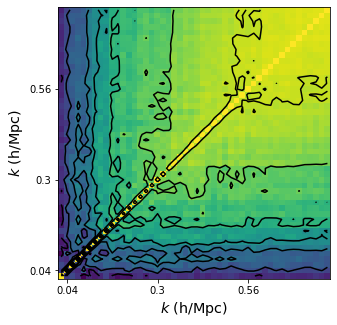

In [10]:
fig,ax1 = plt.subplots(figsize=(5,5))
ax1.imshow(pscorr,origin='lower')
ax1.contour(pscorr,colors='k')
ax1.set_xticks(N.arange(len(kw))[1::16])
ax1.set_yticks(N.arange(len(kw))[1::16])
ax1.set_xticklabels(labels=N.round(kw[1::16],decimals=2))
ax1.set_yticklabels(labels=N.round(kw[1::16],decimals=2))
ax1.set_xlabel(r'$k$ (h/Mpc)',size='x-large')
ax1.set_ylabel(r'$k$ (h/Mpc)',size='x-large')
plt.show()